# Bayesian Interrupted Time Series

Interrupted Time Series (ITS) analysis is a powerful approach for estimating the causal impact of an intervention or treatment when you have a single time series of observations. The key idea is to compare what actually happened after the intervention to what would have happened in the absence of the intervention (the "counterfactual"). To do this, we train a statistical model on the pre-intervention data (when no treatment has occurred) and then use this model to forecast the expected outcomes into the post-intervention period as-if treatment had not occurred. The difference between the observed outcomes and these model-based counterfactual predictions provides an estimate of the causal effect of the intervention, along with a measure of uncertainty if using a Bayesian approach.

:::{note}
**Point intervention vs fixed-period intervention**: This notebook focuses on a **point intervention**, an intervention that occurs at a specific time and continues indefinitely (or at least through the end of the observation period). Note however that it doesn't mean that the _effect_ (if any) of the intervention will persist indefinitely.

For temporary interventions with defined start and end times (a **fixed-period intervention**), you can specify `treatment_end_time` to enable a three-period analysis. This splits the post-intervention period into an intervention period (when treatment is active) and a post-intervention period (after treatment ends), enabling analysis of effect persistence and decay. See {doc}`its_post_intervention_analysis` for a complete example of fixed-period interventions.
:::

## What do we mean by _causal impact_ in Interrupted Time Series?

In the context of interrupted time series analysis, the term **causal impact** refers to the estimated effect of an intervention or event on an outcome of interest. We can break this down into two components which tell us different aspects of the intervention's effect:

- The **Instantaneous Bayesian Causal Effect** at each time point is the difference between the observed outcome and the model's posterior predictive distribution for the counterfactual (i.e., what would have happened without the intervention). This is not just a single number, but a full probability distribution that reflects our uncertainty.
- The **Cumulative Bayesian Causal Impact** is the sum of these instantaneous effects over the post-intervention period, again represented as a distribution.

Let $y_t$ be the observed outcome at time $t$ (after the intervention), and $\tilde{y}_t$ be the model's counterfactual prediction for the same time point. Then:
- **Instantaneous effect:** $\Delta_t = y_t - \tilde{y}_t$
- **Cumulative effect (up to time $T$):** $C_T = \sum_{t=1}^T \Delta_t$

In Bayesian analysis, both $\tilde{y}_t$ and $\Delta_t$ are distributions, not just point estimates.

### Why does this matter for decision making?
These metrics allow you to answer questions like:
- "How much did the intervention change the outcome, compared to what would have happened otherwise?"
- "What is the total effect of the intervention over time, and how certain are we about it?"

By providing both instantaneous and cumulative effects, along with their uncertainty, you can make more informed decisions and better understand the impact of your interventions.

## Interrupted Time Series example

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::


In [4]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


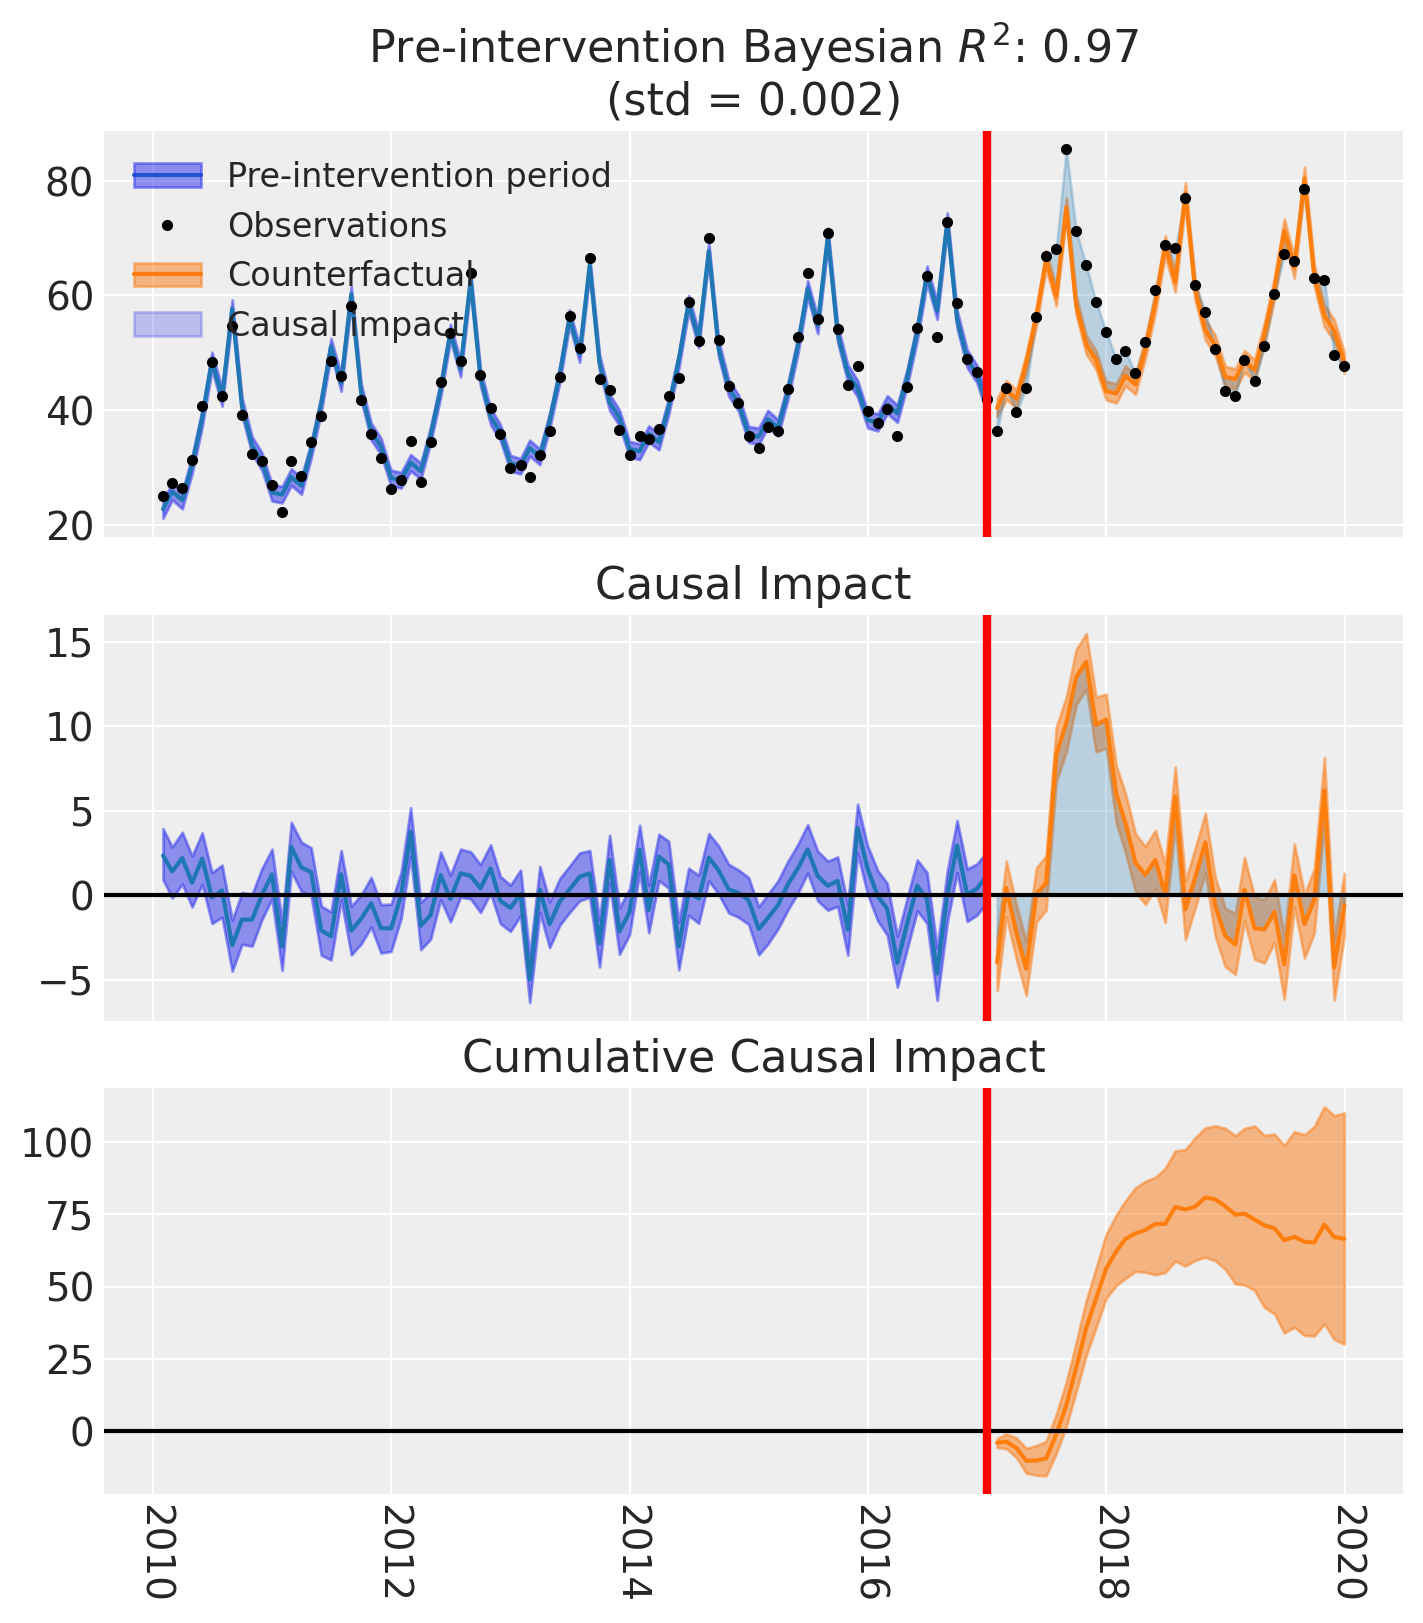

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       23, 94% HDI [21, 24]
    C(month)[T.2]   2.9, 94% HDI [0.91, 4.8]
    C(month)[T.3]   1.2, 94% HDI [-0.87, 3.1]
    C(month)[T.4]   7.2, 94% HDI [5.2, 9.1]
    C(month)[T.5]   15, 94% HDI [13, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   18, 94% HDI [16, 20]
    C(month)[T.8]   33, 94% HDI [32, 35]
    C(month)[T.9]   16, 94% HDI [14, 18]
    C(month)[T.10]  9.2, 94% HDI [7.2, 11]
    C(month)[T.11]  6.3, 94% HDI [4.3, 8.2]
    C(month)[T.12]  0.59, 94% HDI [-1.3, 2.5]
    t               0.21, 94% HDI [0.19, 0.23]
    y_hat_sigma     2, 94% HDI [1.7, 2.3]


As well as the model coefficients, we might be interested in the estimated causal impact of the intervention over time - what we called the instantaneous Bayesian causal effect above. The post intervention causal impact estimates are contained in the `post_impact` attribute, which is of type `xarray.DataArray`. We can take a look at what this looks like, and we can see that it consists of 3 dimensions: `chain`, `draw`, and time (`obs_ind`). The `chain` and `draw` dimensions are used to store the samples from the posterior distribution, while the `obs_ind` dimension corresponds to the time points in the time series.

In [7]:
result.post_impact

<xarray.DataArray (treated_units: 1, chain: 4, draw: 1000, obs_ind: 36)> Size: 1MB
array([[[[-4.41874088, -0.11656654, -2.15732808, ...,  5.3331631 ,
          -4.87021448, -0.134529  ],
         [-4.33955606,  0.33601686, -1.94823964, ...,  6.84608438,
          -4.92820364, -0.46873627],
         [-4.34765512,  1.59893279, -2.07996367, ...,  6.63038663,
          -4.61123016, -1.57491334],
         ...,
         [-2.05144853,  2.80921249,  0.14584911, ...,  6.82599199,
          -2.15164525,  2.76466854],
         [-4.58913211, -0.62178437, -3.26860621, ...,  7.44954799,
          -4.2296152 , -2.46768845],
         [-4.37738668,  0.41420922, -2.18652125, ...,  6.40904424,
          -4.35510501, -0.94727962]],

        [[-4.99633325, -0.94733032, -4.08149671, ...,  3.87033963,
          -4.96395754, -2.00755367],
         [-4.59172985, -0.44895764, -2.07454096, ...,  5.33834856,
          -5.50572629, -0.71032593],
         [-4.55643041,  0.58777896, -3.28804565, ...,  6.49297359,
          -4.01997257, -1.10984942],
...
         [-3.94153494, -0.57878977, -0.74521377, ...,  7.80473156,
          -3.64076609, -1.45615683],
         [-3.99157007,  1.92734563, -2.39041435, ...,  5.21123306,
          -3.51820159,  0.21123832],
         [-4.02073108,  1.08953897, -1.61880617, ...,  7.41339722,
          -3.47210443, -0.29703349]],

        [[-4.86579261, -0.4197439 , -4.04364593, ...,  4.98556932,
          -5.22709894, -1.72547089],
         [-4.19325073,  1.92434779, -2.96534428, ...,  7.39924114,
          -5.00664804, -0.73800996],
         [-3.22324168,  0.25818213, -1.30470419, ...,  7.12281238,
          -3.4182243 ,  0.34059839],
         ...,
         [-3.38787441, -0.99567554, -2.25897221, ...,  6.79361851,
          -4.30457316, -0.86454344],
         [-3.0102365 , -1.46631371, -1.46806508, ...,  6.15894847,
          -4.76758847, -0.3965738 ],
         [-3.0247343 ,  2.54699839, -3.37878498, ...,  6.2597354 ,
          -4.93868466, -0.670456  ]]]], shape=(1, 4, 1000, 36))
Coordinates:
  * treated_units  (treated_units) <U6 24B 'unit_0'
  * chain          (chain) int64 32B 0 1 2 3
  * draw           (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * obs_ind        (obs_ind) datetime64[us] 288B 2017-01-31 ... 2019-12-31

We have already seen a visual representation of this - the middle plot (see above) generated when calling the `plot` method. But often we would like to reduce this down to a simpler estimate. We can do this by various aggregation methods.

If we wanted to evaluate the total causal impact (or what we called the cumulative Bayesian causal effect) of the intervention over the whole post-intervention period, we can use the `sum` method. This will sum the post-intervention impact estimates across all time points in the post-intervention period.

In [8]:
az.plot_posterior(
    result.post_impact.sum("obs_ind"),
    ref_val=0,
    hdi_prob=0.94,
    round_to=3,
    figsize=(7, 2),
);

So we could say that the most credible total causal impact of the intervention is around 66, with a 94% credible interval of around 20 to 110.

And if we want precise numerical and summary statistics of that, we can use the `arviz.summary` function:

In [9]:
az.summary(result.post_impact.sum("obs_ind"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[unit_0],66.552,21.229,30.169,110.076


Of course, if we wanted to query the estimated impact over a specific time period, we can leverage the fact that this is an `xarray.DataArray` and we can use the `sel` method to select the time points we are interested in. We will leave this as an exercise for the reader.

Moving on, it would also be possible to look at the mean post-intervention impact estimates, which would give us the average impact of the intervention over the post-intervention period. This can be done using the `mean` method and would equate to $\bar{C_T} = \Big[ \sum_{t=1}^T \Delta_t \Big] / T$

In [10]:
az.summary(result.post_impact.mean("obs_ind"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[unit_0],1.849,0.59,0.838,3.058


:::{warning}
Care must be taken with the mean causal impact statistic $\bar{C_T}$. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient (like in the example here), then clearly there will be a lot of post-intervention period where the impact of the intervention has ‘worn off’. If so, then it will be hard to interpret the mean impacts real meaning.

But if there was a roughly constant impact of the intervention over the post-intervention period, then the mean causal impact can be interpreted as the mean impact of the intervention (per time point) over the post-intervention period.
:::

## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with:

- Average and cumulative effects over a time window
- Highest Density Intervals (HDI) for uncertainty quantification
- Tail probabilities (e.g., P(effect > 0))
- Relative effects (% change vs counterfactual)

This provides a comprehensive summary without manual post-processing.


In [11]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,1.848666,1.847213,0.756824,3.102934,0.9985,3.354617,1.261679,5.657124
cumulative,66.551983,66.499680,27.245669,111.705613,0.9985,3.354617,1.261679,5.657124


In [12]:
print(stats.text)

Post-period (2017-01-31 00:00:00 to 2019-12-31 00:00:00), the average effect was 1.85 (95% HDI [0.76, 3.10]), with a posterior probability of an increase of 0.999. The cumulative effect was 66.55 (95% HDI [27.25, 111.71]); probability of an increase 0.999. Relative to the counterfactual, this equals 3.35% on average (95% HDI [1.26%, 5.66%]).


You can customize the summary in several ways:

- **Window**: Analyze a specific time period instead of the full post-period
- **Direction**: Specify whether you're testing for an increase, decrease, or two-sided effect
- **Alpha**: Set the HDI confidence level (default 95%)
- **Options**: Include/exclude cumulative or relative effects


In [13]:
# Example: Analyze first 6 months of post-period with two-sided test
post_dates = result.datapost.index
window_start = post_dates[0]
window_end = post_dates[5]  # First 6 months

stats_windowed = result.effect_summary(
    window=(window_start, window_end),
    direction="two-sided",
    alpha=0.05,
    cumulative=True,
    relative=True,
)
stats_windowed.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-1.569287,-1.564943,-2.674320,-0.578891,0.005,0.995,-3.165605,-5.29513,-1.195812
cumulative,-9.415723,-9.389658,-16.045922,-3.473345,0.005,0.995,-3.165605,-5.29513,-1.195812


In [14]:
print(stats_windowed.text)

Post-period (2017-01-31 00:00:00 to 2017-06-30 00:00:00), the average effect was -1.57 (95% HDI [-2.67, -0.58]), with a posterior probability of an effect of 0.995. The cumulative effect was -9.42 (95% HDI [-16.05, -3.47]); probability of an effect 0.995. Relative to the counterfactual, this equals -3.17% on average (95% HDI [-5.30%, -1.20%]).


Similarly, if we wanted, we would also be able to query the estimated cumulative impact of the intervention over the post-intervention period by instead looking at the `post_impact_cumulative` attribute, rather than the `post_impact` attribute.

## Sensitivity analysis

### Placebo-in-time test

A key assumption of ITS is that no other event coincided with the intervention to produce the observed change. If this assumption is violated, we cannot attribute the observed shift to the intervention alone {cite:p}`campbell1963experimental`.

A {term}`placebo-in-time` test probes this by shifting the treatment date into the pre-intervention window and re-fitting the model at each "pseudo" treatment time. If the model detects a significant effect at a time when no intervention occurred, this casts doubt on the original causal claim. A well-specified model should show no significant effect at any placebo treatment time.

**How it works.** The pre-intervention period is divided into *n* folds. For each fold, a pseudo treatment time is chosen, the data are truncated to end at the corresponding pseudo post-treatment boundary, and the model is re-fit. The estimated effect at each pseudo treatment time is compared against zero.

**Interpreting the output.** If none of the placebo folds show a significant effect, the check **passes** — this is evidence that the model is not picking up pre-existing trends or seasonal patterns as treatment effects. Folds that fall before the data range are skipped. If any fold shows a significant effect, the check **fails**, suggesting the model may be mis-specified or that confounding events are present.

In [15]:
sensitivity_result = cp.Pipeline(
    data=df,
    steps=[
        cp.EstimateEffect(
            method=cp.InterruptedTimeSeries,
            treatment_time=treatment_time,
            formula="y ~ 1 + t + C(month)",
            model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
        ),
        cp.SensitivityAnalysis(
            checks=[
                cp.checks.PlaceboInTime(n_folds=3),
            ]
        ),
        cp.GenerateReport(include_plots=True),
    ],
).run()

for cr in sensitivity_result.sensitivity_results:
    print(f"{cr.check_name}: {cr.text}")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Fold 1 failed to fit (pseudo_treatment_time=2008-01-07 00:00:00), skipping.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


There were 513 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


PlaceboInTime: Placebo-in-time analysis: 2 of 3 folds completed (1 skipped).
PASSED — no spurious effects detected in any fold.
Fold 1: SKIPPED (experiment failed to fit at pseudo treatment time 2008-01-07 00:00:00)
Fold 2: pseudo treatment at 2011-01-05 00:00:00 — PASS (null)
Fold 3: pseudo treatment at 2014-01-03 00:00:00 — PASS (null)



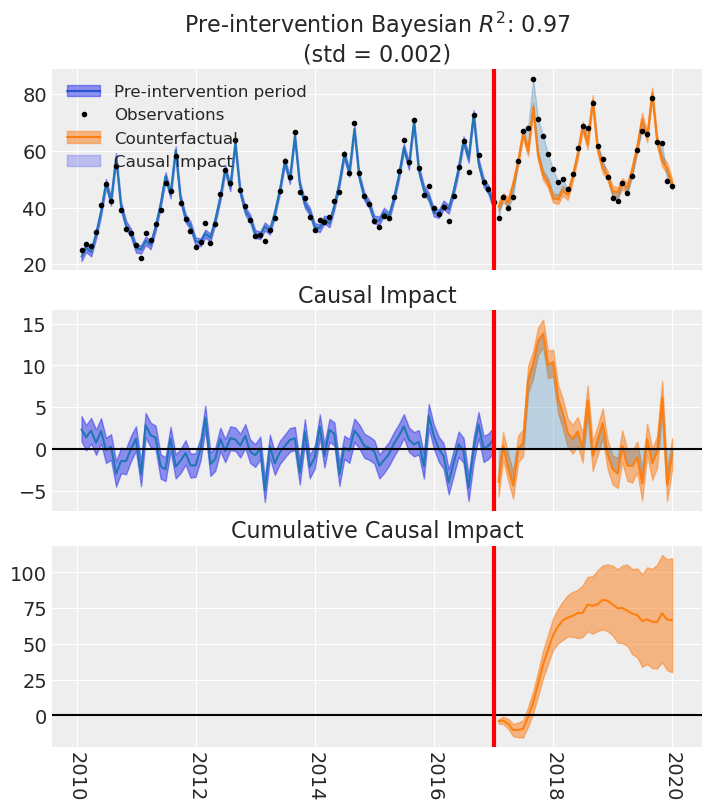

In [16]:
import html as html_module
import warnings

from IPython.display import HTML

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", "Consider using IPython.display.IFrame", UserWarning
    )
    report_widget = HTML(
        '<iframe srcdoc="'
        + html_module.escape(sensitivity_result.report)
        + '" width="100%" height="1000"'
        ' style="border: 1px solid #ddd; border-radius: 6px;"></iframe>'
    )
report_widget

:::{bibliography}
:filter: docname in docnames
:::